In [266]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import initializers


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [277]:
#load the data
data = pd.read_csv('outputs/density-data-all-100-stdev', sep=" ", header=None)
data.head()
data.columns = ['rho', 'potential', 'temp', 'stdev_pe', 'stdev_temp']
x = data.drop(['potential', 'temp'], axis=1)
y = data.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)

#split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
# train, test = train_test_split(data, test_size=0.2)

In [307]:
#splitting into k-folds
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)


In [279]:
#shuffle training data
# train_data = shuffle(train)

#separating output from x
# x_train = train_data.drop(['potential', 'temp'], axis=1)
# y_train = train_data.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)

# x_test = test.drop(['potential', 'temp'], axis=1)
# y_test = test.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)

#Separating error bars from x
error_bars_train = x_train.drop(['rho'], axis=1)
x_train = x_train.rho
error_bars_test = x_test.drop(['rho'], axis=1)
x_test = x_test.rho

# print("\n test data:", x_test[0:50], "\n", y_test[0:50])


In [280]:
#Normalization
x_train_reshape = x_train.values.reshape((-1,1))
x_test_reshape = x_test.values.reshape((-1,1))

y_train_reshape = y_train.values.reshape((-1,2))
y_test_reshape = y_test.values.reshape((-1,2))

# print(y_train_reshape)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(x_train_reshape)
xtrain_scale=scaler_x.transform(x_train_reshape)
scaler_x.fit(x_test_reshape)
xtest_scale=scaler_x.transform(x_test_reshape)
scaler_y.fit(y_train_reshape)
ytrain_scale=scaler_y.transform(y_train_reshape)
scaler_y.fit(y_test_reshape)
ytest_scale=scaler_y.transform(y_test_reshape)
# print(xtrain_scale)
# print(ytrain_scale)

In [281]:
# Merge inputs and targets for k-fold
# inputs = np.concatenate((xtrain_scale, xtest_scale), axis=0)
# targets = np.concatenate((ytrain_scale, ytest_scale), axis=0)
# print(inputs.shape)
# print(targets.shape)

In [282]:
# def custom_accuracy (y_actual, y_predicted):
#   # predictions_transformed = scaler_y.inverse_transform(y_predicted)
#   lower_limit = y_actual - error_bars_test.stdev_pe
#   upper_limit = y_actual + error_bars_test.stdev_pe
#   hits = 0
#   filter = tf.math.logical_and(y_predicted >= lower_limit, y_predicted < upper_limit, name="and")
#   hits = tf.sum(filter)

#   return hits/169
# print("Accuracy:",acc*100, "% hits:", hits, " ", i)

In [308]:
#define the model
model = keras.Sequential()
model.add(Dense(1, input_dim=1, kernel_initializer= tf.keras.initializers.Ones(), activation='relu', name='input_layer'))
model.add(Dense(5, activation='relu', name="hidden_layer"))
model.add(Dense(2, activation='linear', name="output_layer"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.summary()
# 'random_uniform'


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 2         
_________________________________________________________________
hidden_layer (Dense)         (None, 5)                 10        
_________________________________________________________________
output_layer (Dense)         (None, 2)                 12        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [309]:
# new_model = keras.models.load_model("model_5neurons_0.001LR_600epoch_5batch")
# predictions = new_model.predict(xtest_scale)

In [310]:
# model.save("/content/drive/MyDrive/Colab Notebooks/model_5neurons_0.001LR_600epoch_5batch") #"/content/drive/MyDrive/Colab Notebooks/mymodel")
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoints/my_checkpoint')

In [311]:
#training through each fold
fold_no = 1
cvscores = []
for train, validate in kfold.split(xtrain_scale, ytrain_scale):
    print("\n Fold:", fold_no)
    fold_no+=1
    #compile the model
    model.compile(loss='mse', optimizer=opt, metrics=['mae', 'accuracy'])
    history=model.fit(xtrain_scale[train], ytrain_scale[train], epochs=100, batch_size=1, verbose=0)
    # evaluate the model
    scores = model.evaluate(xtrain_scale[validate], ytrain_scale[validate], verbose=0)
    print("%s: %.2f%%",(model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



 Fold: 1
%s: %.2f%% ('mean_absolute_error', 0.042252336)

 Fold: 2
%s: %.2f%% ('mean_absolute_error', 0.03848268)

 Fold: 3
%s: %.2f%% ('mean_absolute_error', 0.037148878)

 Fold: 4
%s: %.2f%% ('mean_absolute_error', 0.02721316)

 Fold: 5
%s: %.2f%% ('mean_absolute_error', 0.012750795)



 cvscores: [0.042252336, 0.03848268, 0.037148878, 0.02721316, 0.012750795]


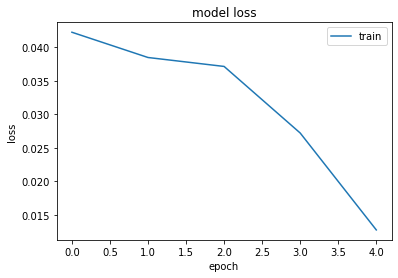

In [312]:

# print(history.history.keys())
# print(history.history.get('acc')[-1])
print("\n cvscores:", cvscores)
plt.plot(cvscores)
plt.title('model loss')
# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [313]:
predictions = model.predict(xtest_scale)
predictions_transformed = scaler_y.inverse_transform(predictions)
# predictions_transformed2 = scaler_y.inverse_transform([predictions[50:100]])
# predictions_transformed3 = scaler_y.inverse_transform([predictions[100:]])
predicted_data = pd.DataFrame(predictions_transformed)
predicted_data.columns = ['pe', 'temp']
# print(y_test)
#calculating accuracy
hits = 0
i = 0
print(y_test.shape)
for index, row in y_test.iterrows():
  lower_limit = row['potential']-error_bars_test.stdev_pe[index]
  upper_limit = row['potential']+error_bars_test.stdev_pe[index]
  #print("\n upper limit:",upper_limit," lower limit:",lower_limit," prediction:",predicted_data.pe[i])
  if predicted_data.pe[i] > lower_limit and predicted_data.pe[i] < upper_limit:
    # print(" hit")
    hits += 1
  print(x_test[index],",", y_test.potential[index],",",predicted_data.pe[i],",",error_bars_test.stdev_pe[index])
  i+=1

acc = hits/(i)
print("Success Rate:",acc*100, "% hits:", hits, " ", i)

(169, 2)
0.318 , -3.565 , -3.5414207 , 0.04
0.48 , -3.6460000000000004 , -3.6363192 , 0.036000000000000004
0.35200000000000004 , -3.5839999999999996 , -3.5613377 , 0.045
0.71 , -4.145 , -4.1462083 , 0.032
0.541 , -3.677 , -3.6720521 , 0.038
0.718 , -4.178 , -4.177176 , 0.032
0.24100000000000002 , -3.5039999999999996 , -3.5173926 , 0.066
0.28300000000000003 , -3.535 , -3.5209181 , 0.059000000000000004
0.135 , -3.471 , -3.5173926 , 0.052000000000000005
0.92 , -4.985 , -4.9900045 , 0.044000000000000004
0.9229999999999999 , -4.996 , -5.002328 , 0.042
0.927 , -5.01 , -5.018759 , 0.042
0.863 , -4.744 , -4.7558613 , 0.044000000000000004
0.789 , -4.462 , -4.452016 , 0.04
0.28 , -3.534 , -3.5191607 , 0.053
0.831 , -4.62 , -4.6244125 , 0.042
0.27899999999999997 , -3.535 , -3.518575 , 0.053
0.9470000000000001 , -5.07 , -5.1009145 , 0.040999999999999995
0.767 , -4.373 , -4.3668547 , 0.04
0.47600000000000003 , -3.6319999999999997 , -3.633976 , 0.037000000000000005
0.7659999999999999 , -4.368 , -4.3

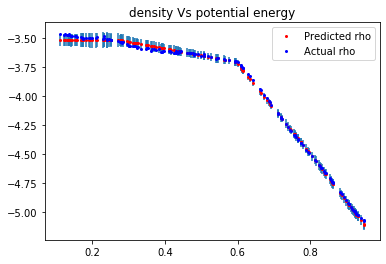

0    -3.541421
1    -3.636319
2    -3.561338
3    -4.146208
4    -3.672052
5    -4.177176
6    -3.517393
7    -3.520918
8    -3.517393
9    -4.990005
10   -5.002328
11   -5.018759
12   -4.755861
13   -4.452016
14   -3.519161
15   -4.624413
16   -3.518575
17   -5.100914
18   -4.366855
19   -3.633976
20   -4.362983
21   -3.703685
22   -4.033950
23   -5.035190
24   -4.517611
25   -3.517393
26   -3.624603
27   -4.480641
28   -3.597071
29   -4.957142
30   -4.184918
31   -3.702514
32   -3.560752
33   -5.010543
34   -3.517393
35   -4.649059
36   -4.281693
37   -4.669598
38   -3.517393
39   -3.567781
40   -4.324274
41   -3.517393
42   -3.782336
43   -3.631633
44   -4.998220
45   -3.517393
46   -3.566610
47   -3.611716
48   -3.659165
49   -3.517393
Name: pe, dtype: float32
209    0.040
371    0.036
243    0.045
601    0.032
432    0.038
609    0.032
132    0.066
174    0.059
26     0.052
811    0.044
814    0.042
818    0.042
754    0.044
680    0.040
171    0.053
722    0.042
170    0.053
838 

In [314]:
plt.plot(x_test,predicted_data.pe,"ro", markersize=2)
plt.plot(x_test,y_test.potential,"bo", markersize=2)
plt.errorbar(x_test, predicted_data.pe, yerr =error_bars_test.stdev_pe, fmt=" ")
plt.legend(['Predicted rho','Actual rho'], loc='upper right')
plt.title('density Vs potential energy')
plt.show()

print(predicted_data.pe[0:50])
print(error_bars_test.stdev_pe[0:50])